In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
df = pd.read_csv('styles.csv', on_bad_lines='skip')
df = df[['id', 'articleType']].dropna()
df['image'] = df['id'].astype(str) + '.jpg'
df = df[df['image'].apply(lambda x: os.path.exists(os.path.join('images', x)))]

In [3]:
top_classes = df['articleType'].value_counts().nlargest(10).index.tolist()
df = df[df['articleType'].isin(top_classes)].reset_index(drop=True)

In [23]:
print("🧥 Top 10 Clothing Categories Used for Training:")
print(df['articleType'].value_counts().nlargest(10))


🧥 Top 10 Clothing Categories Used for Training:
articleType
Tshirts         892
Shirts          773
Casual Shoes    461
Sports Shoes    240
Kurtas          225
Watches         191
Tops            179
Heels           166
Formal Shoes    126
Jeans           126
Name: count, dtype: int64


In [16]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['articleType'])
num_classes = len(label_encoder.classes_)
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['articleType'])

# Save raw labels BEFORE to_categorical
y_raw = np.array(df['label'])

# Use for training
y = to_categorical(y_raw)


In [17]:
IMG_SIZE = (128, 128)
X = []
y = []

for i, row in df.iterrows():
    path = os.path.join('images', row['image'])
    try:
        img = Image.open(path).convert('RGB').resize(IMG_SIZE)
        X.append(np.array(img))
        y.append(row['label'])
    except:
        continue

X = np.array(X) / 255.0  # Normalize
y = to_categorical(np.array(y), num_classes=num_classes)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [19]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)


In [20]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

c:\Users\Bhumika\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_raw),
    y=y_raw
)
class_weights_dict = dict(enumerate(class_weights))


In [22]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=10,
    class_weight=class_weights_dict
)


c:\Users\Bhumika\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 392ms/step - accuracy: 0.1427 - loss: 2.3279 - val_accuracy: 0.4822 - val_loss: 1.5528
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 32s 376ms/step - accuracy: 0.3621 - loss: 1.6723 - val_accuracy: 0.6080 - val_loss: 1.1299
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 34s 398ms/step - accuracy: 0.4483 - loss: 1.3029 - val_accuracy: 0.6302 - val_loss: 0.9629
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 33s 384ms/step - accuracy: 0.4989 - loss: 1.1470 - val_accuracy: 0.6183 - val_loss: 0.9287
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 34s 402ms/step - accuracy: 0.5435 - loss: 1.0701 - val_accuracy: 0.6139 - val_loss: 0.8770
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 34s 396ms/step - accuracy: 0.5372 - loss: 1.0406 - val_accuracy: 0.6967 - val_loss: 0.7736
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 33s 386ms/step - accuracy: 0.5783 - loss: 0.9788 - val_accuracy: 0.6864 - val_loss: 0.7371
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 32s 381ms/step - accuracy: 0.5859 - loss: 0.9223 - val_accu

In [24]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\n✅ Final Test Accuracy: {accuracy * 100:.2f}%")

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.6977 - loss: 0.6873

✅ Final Test Accuracy: 72.04%


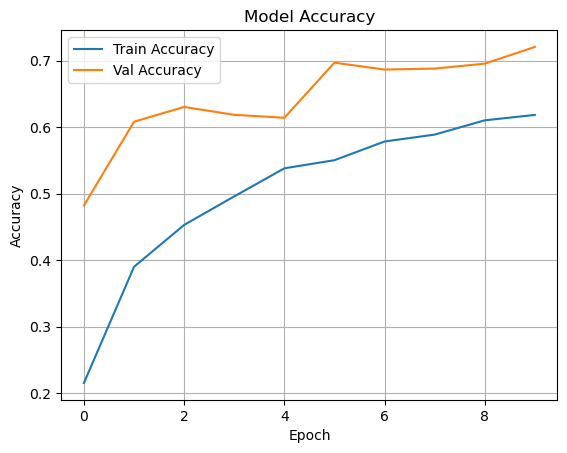

In [25]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
import joblib
joblib.dump(label_encoder, "label_encoder.joblib")


['label_encoder.joblib']

In [28]:
model.save('model.h5')